# Probabilistic Prediction

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/pymc-labs/ai_decision_workshop/blob/main/notebooks/04_prediction.ipynb)

In [1]:
import arviz as az
import numpy as np
import matplotlib.pyplot as plt
import pymc as pm

plt.rcParams['figure.dpi'] = 75
plt.rcParams['figure.figsize'] = (6.4, 3.2)

np.set_printoptions(precision=6, suppress=True)

## Distributions of Probabilities

Suppose we have two coins:

* One is known to be fair, so the probability of heads is 50%.

* The other is known to be biased, but it is equally likely that the probability of heads is 30% or 70%.

If we flip each coin only once, the probability of heads is 50% for both coins.
So it is tempting to think there is no difference: the outcome depends only on the mean probability.

But that's not true in general. For example, suppose we toss each coin 10 times.
For the fair coin, the distribution of outcomes is a simple binomial.

In [2]:
from scipy.stats import binom

n = 10
binomial_dist = binom(n=n, p=0.5)

And we can compute its PMF like this.

In [3]:
ks = np.arange(n+1)
pmf_fair = binomial_dist.pmf(ks)

For the biased coin, there are two possible distributions.

In [4]:
binomial_dist1 = binom(n=n, p=0.3)
binomial_dist2 = binom(n=n, p=0.7)

And we can compute the overall PMF by averaging them (in this case because 30% and 70% are equally likely).

In [5]:
pmf1 = binomial_dist1.pmf(ks)
pmf2 = binomial_dist2.pmf(ks)
pmf_biased = (pmf1 + pmf2) / 2

The result is a mixture of two binomials.

Here's what the two predictive distributions look like.

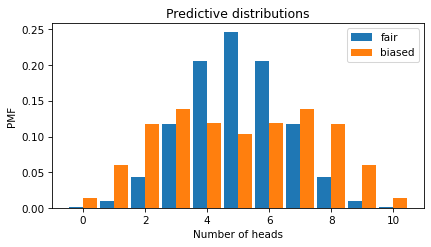

In [6]:
width = 0.45
plt.bar(ks, pmf_fair, label='fair', align="edge", width=-width)
plt.bar(ks, pmf_biased, label='biased', align="edge", width=width)
plt.xlabel('Number of heads')
plt.ylabel('PMF')
plt.title('Predictive distributions')
plt.legend();

They are substantially different! In particular, the biased coin is more likely to produce extreme results.

In general, if we have a distribution of probabilities, the predictive distribution is a mixture of binomials.

In the philosophy of probability, so-called "second order probabilities" have sometimes been considered problematic.
In the Bayesian interpretation of probability, they are unproblematically meaningful and practically useful.

## Predicting Disaster

Suppose you are designing a safety critical system, like a nuclear power plant, a medical device, or an autonomous vehicle.
You have identified five components of the system that might fail, and estimated that there is a 5% chance that any one of them fails during a particular period of time.
Fortunately, these components are redundant, so the system only fails if *all five of the components fail*.

If the probability of failure is known to be precisely 5%, the probability of five simultaneous failures is 0.05 raised to the fifth power, which is small.

In [7]:
0.05 ** 5

3.125000000000001e-07

But let's see what happens if we add some uncertainty to that estimate.
We'll use a beta distribution to represent uncertainty about the probability of failure.

In [8]:
from scipy.stats import beta as beta_dist

mean = 0.05
std = 0.001

alpha = mean * ((mean * (1 - mean)) / std**2 - 1)
beta = (1 - mean) * ((mean * (1 - mean)) / std**2 - 1)

In [9]:
dist = beta_dist(alpha, beta)
print(dist.mean(), dist.std())

0.05000000000000002 0.0010000000000000002


Here's what that distribution looks like.

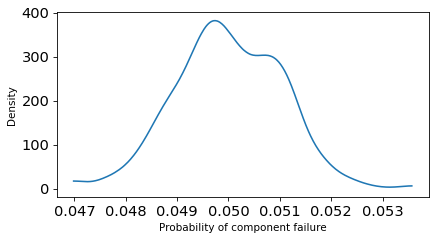

In [10]:
sample = dist.rvs(1000)
az.plot_kde(sample)
plt.xlabel('Probability of component failure')
plt.ylabel('Density');

To estimate the probability of **system failure**, we'll draw 1000 values from the beta distribution and compute the fifth power of each.

In [11]:
sample = dist.rvs(1000)**5
print(sample.mean())

3.131195002480362e-07


Here's what the distribution looks like for the probability of system failure.

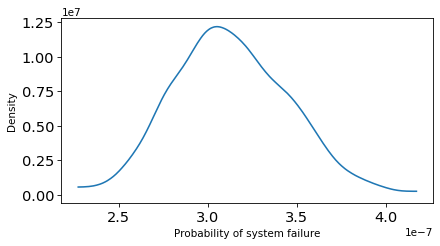

In [12]:
az.plot_kde(sample)
plt.xlabel('Probability of system failure')
plt.ylabel('Density');

When the uncertainty is small, the probability of system failure is still small.

Exercise: Go back and increase `std`. The mean probability of component failure should stay the same, but see what happens to the mean probability of system failure.

Note: The way we are modeling this scenario, we assume that the probability of failure is the same for all five components. But the same effect happens if they are not identical, but correlated -- that is, if one of them turns out to be higher than expected, it's more likely that they others are, too. If they are uncorrelated, or only weakly correlated, we don't have the same problem.